In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
#Se leen los dataset de animes y los ratings de ellos
rating_info = pd.read_csv('/content/rating.csv')
anime_info = pd.read_csv('/content/anime.csv')

#Algunos ejemplos del dataset anime y ratings
anime_info.head(15)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


In [0]:
#Se obtienen la cantidad de animes, la cantidad de animes con raiting y los usuarios del dataset
lista_anime = anime_info.anime_id.unique()
lista_calif_anime = rating_info.anime_id.unique()
lista_usuario = rating_info.user_id.unique()

In [0]:
rating_info.head(15)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1
6,1,356,-1
7,1,442,-1
8,1,487,-1
9,1,846,-1


In [0]:
#Se limpian los resultado de los ratings los cuales sean -1 o no evaluados
rating_info.drop(rating_info[rating_info.rating == -1].index, inplace=True)
#Se vuelve a calcular los indices de cada anime y su rating con la lista filtrada
rating_info.reset_index(drop=True, inplace=True)


In [0]:
#Se agrega a cada anime el indice que tiene para poder indexar elementos ya que 
# no se puede agregar elementos con su anime_id ya que si lo intentaraos con ello se tendrian errores.
anime_info['anime_indice'] = anime_info.index
anime_info.head(15)

,anime_id,name,genre,type,episodes,rating,members,anime_indice
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,1
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,2
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,3
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,4
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351,5
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855,6
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679,7
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534,8
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109,9


In [0]:
#Se reordenan los datos, de forma que tengamos todos los ratings de cada anime con el usuario que lo hizo 
orden_datos = pd.merge(rating_info[['user_id', 'anime_id', 'rating']], anime_info[['anime_id', 'anime_indice']], on='anime_id')
orden_datos.head(15)

,user_id,anime_id,rating,anime_indice
0,1,8074,10,1709
1,3,8074,6,1709
2,5,8074,2,1709
3,12,8074,6,1709
4,14,8074,6,1709
5,17,8074,7,1709
6,24,8074,7,1709
7,27,8074,9,1709
8,29,8074,2,1709
9,30,8074,8,1709


In [0]:
#Se agrupan los datos por usuario para saber que animes ha calificado el usuario, 
# se muestran los primeros 15 usuarios y sus primeras calificaciónes a animes
datos_agrupados = orden_datos.groupby('user_id')
datos_agrupados.first().head(15)

,anime_id,rating,anime_indice
user_id,,,
1,8074,10,1709
2,11771,10,122
3,8074,6,1709
5,8074,2,1709
7,11617,6,1057
8,11757,9,804
9,1887,8,729
10,11757,9,804
11,11757,8,804


In [0]:
max_rating = rating_info.rating.max()

# Se establece el número de usuarios usados para el entrenamiento
numUsuarios = 1000

# Se crea una lista para el entrenamiento
entrenamientos = []

# Se busca por cada usuario las calificaciónes que ha dado
for id_Usuario, usuario in datos_agrupados:

    # Se crea una lista de las calificaciones de cada anime
    aux = [0]*len(lista_anime)

    # Se obtienen las calificaciones a animes del usuario actual
    for num, anime in usuario.iterrows():

        # Se divide la calificación del anime entre la total
        aux[anime['anime_indice']] = anime.rating/max_rating

    # Se agrega el ejemplar a la lista de entrenamiento
    entrenamientos.append(aux)

    if numUsuarios == 0:
        break
    numUsuarios -= 1

In [0]:
# Paramentros para el modelo
nodos_escondidos = 50
nodos_visibles = len(lista_anime)
nv = tf.placeholder(tf.float32, [nodos_visibles])  # Numero de animes
no = tf.placeholder(tf.float32, [nodos_escondidos])  # Numero de caracteristicas a aprender/estimar
W = tf.placeholder(tf.float32, [nodos_visibles, nodos_escondidos])  # Matriz de pesos

In [0]:
# Procesamiento de las información de entrada
v0 = tf.placeholder("float", [None, nodos_visibles])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + no)  # Capa de activación para los nodos visibles
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))  # Muestro de Gibb

In [0]:
# Recontrucción de los datos
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + nv)  # Capa de activación para los nodos ocultos
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1)))) # Muestro de Gibb
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + no)

In [0]:
#Se crean los paramentros de entrada

# Taza de aprendizaje
t_aprendizaje = 1.0

# Creacion de los gradientes
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

# Calculamos la Contrastive Divergence para mejorar los resultados
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Se actualizan los pesos y los sesgos
actualiza_pesos = W + t_aprendizaje * CD
actualiza_nv = nv + t_aprendizaje * tf.reduce_mean(v0 - v1, 0)
actualiza_no = no + t_aprendizaje * tf.reduce_mean(h0 - h1, 0)

# Se crea la función de error, en este caso se usara Mean Absolute Error
error = v0 - v1
sum_error = tf.reduce_mean(error*error)

In [0]:
# Se inicializaran las variables para el entrenamiento
# Pesos actuales del entrenamiento
pesos_ent = np.zeros([nodos_visibles, nodos_escondidos], np.float32)

# Sesgos actuales de los nodos visibles del entrenamiento 
sesgosvi_ent = np.zeros([nodos_visibles], np.float32)

# Sesgos actuales de los nodos ocultos del entrenamiento
sesgosoc_ent = np.zeros([nodos_escondidos], np.float32)

# Pesos anteriores del entrenamiento
pesos_ant = np.zeros([nodos_visibles, nodos_escondidos], np.float32)

# Sesgos previos de los nodos visibles del entrenamiento
sesgos_antvi = np.zeros([nodos_visibles], np.float32)

# Sesgos previos de los nodos ocultos del entrenamiento
sesgos_anteoc = np.zeros([nodos_escondidos], np.float32)

sesion = tf.Session()
sesion.run(tf.global_variables_initializer())

0.087851964
0.04910473
0.034237716
0.021704277
0.014766656
0.011096939
0.009714997
0.009266543
0.009035849
0.00879433
0.008654158
0.008498774
0.0084418105
0.008345227
0.008310902


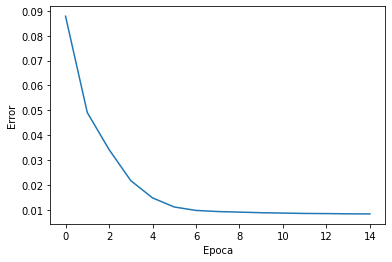

In [0]:
# Se entrenará la RBM en 15 epocas con 10 lotes de tamaño 100 
epocas = 15
tam_lote = 100
error = []
for i in range(epocas):
    for inicio, fin in zip(range(0, len(entrenamientos), tam_lote), range(tam_lote, len(entrenamientos), tam_lote)):
        lote = entrenamientos[inicio:fin]
        pesos_ent = sesion.run(actualiza_pesos, feed_dict={v0: lote, W: pesos_ant, nv: sesgos_antvi, no: sesgos_anteoc})
        sesgosvi_ent = sesion.run(actualiza_nv, feed_dict={v0: lote, W: pesos_ant, nv: sesgos_antvi, no: sesgos_anteoc})
        sesgosoc_ent = sesion.run(actualiza_no, feed_dict={v0: lote, W: pesos_ant, nv: sesgos_antvi, no: sesgos_anteoc})
        pesos_ant = pesos_ent
        sesgos_antvi = sesgosvi_ent
        sesgos_anteoc = sesgosoc_ent
    error.append(sesion.run(sum_error, feed_dict={v0: entrenamientos, W: pesos_ent, nv: sesgosvi_ent, no: sesgosoc_ent}))
    print(error[-1])
plt.plot(error)
plt.ylabel('Error')
plt.xlabel('Epoca')
plt.show()

In [0]:
#Ahora con la red entrenada podemos tomar los datos de un usuario, aplicarselo a la RBM y que reconstruya la entrada dandonos 
# como resultado valores que nos ayudaran a darle animes recomendados al usuario que no haya visto

# Select the example User
Usuario_prueba = [entrenamientos[80]]

In [0]:
# Se da como entrada el usuario a la red y se trata de reconstruir la entrada
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + no)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + nv)
entrada = sesion.run(hh0, feed_dict={v0: Usuario_prueba, W: pesos_ant, no: sesgos_anteoc})
recomendaciones = sesion.run(vv1, feed_dict={hh0: entrada, W: pesos_ant, nv: sesgos_antvi})

In [0]:
# Se muestran los diez animes recomendados para el usuario con el valor que da la nuestra red
recomendaciones_usuario = anime_info
recomendaciones_usuario["Que tan recomendable es"] = recomendaciones[0]
recomendaciones_usuario.sort_values(["Que tan recomendable es"], ascending=False).head(10)

,anime_id,name,genre,type,episodes,rating,members,anime_indice,Que tan recomendable es
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297,841,0.179105
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917,40,0.117979
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151,19,0.054991
643,9919,Ao no Exorcist,"Action, Demons, Fantasy, Shounen, Supernatural",TV,25,7.92,583823,643,0.054588
10,4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24,9.06,456749,10,0.052776
164,853,Ouran Koukou Host Club,"Comedy, Harem, Romance, School, Shoujo",TV,26,8.39,422271,164,0.051441
582,269,Bleach,"Action, Comedy, Shounen, Super Power, Supernat...",TV,366,7.95,624055,582,0.050866
830,10793,Guilty Crown,"Action, Drama, Sci-Fi, Super Power",TV,22,7.81,460959,830,0.039709
440,3588,Soul Eater,"Action, Adventure, Comedy, Fantasy, Shounen, S...",TV,51,8.08,580184,440,0.034689
449,22319,Tokyo Ghoul,"Action, Drama, Horror, Mystery, Psychological,...",TV,12,8.07,618056,449,0.029477


In [0]:
#Ahora teniendo los resultados de la red, se daran los animes que no se hayan visto por el usuario
# Buscamos el ID del usuario de entrada
orden_datos.iloc[80]

user_id          286
anime_id        8074
rating             7
anime_indice    1709
Name: 80, dtype: int64

In [0]:
# Se buscan los animes que ha visto el usuario
calif_para_usuario = orden_datos[orden_datos['user_id'] == 286]
calif_para_usuario.head()

,user_id,anime_id,rating,anime_indice
80,286,8074,7,1709
31765,286,11757,10,804
196510,286,1535,9,40
258056,286,3588,8,440
276079,286,5114,7,1


In [0]:
# Fusionamos los datos de las recomendaciones del usuario y todos los animes
orden_datos_us = recomendaciones_usuario.merge(calif_para_usuario, on='anime_id', how='outer')
orden_datos_us.head()

,anime_id,name,genre,type,episodes,rating_x,members,anime_indice_x,Que tan recomendable es,user_id,rating_y,anime_indice_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,0,0.000530,NaN,NaN,NaN
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,1,0.017581,286.0,7.0,1.0
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,2,0.000032,NaN,NaN,NaN
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,3,0.000841,NaN,NaN,NaN
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,4,0.000099,NaN,NaN,NaN


In [0]:
# Quitamos los datos de la red innecesarios
orden_datos_us = orden_datos_us.drop('anime_indice_y', axis=1).drop('user_id', axis=1)

In [0]:
# Ordenamos los animes por el valor de recomendación al usuario y mostramos los primeros 10
orden_datos_us.sort_values(['Que tan recomendable es'], ascending=False).head(10)

,anime_id,name,genre,type,episodes,rating_x,members,anime_indice_x,Que tan recomendable es,rating_y
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297,841,0.179105,NaN
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917,40,0.117979,9.0
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151,19,0.054991,NaN
643,9919,Ao no Exorcist,"Action, Demons, Fantasy, Shounen, Supernatural",TV,25,7.92,583823,643,0.054588,NaN
10,4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24,9.06,456749,10,0.052776,NaN
164,853,Ouran Koukou Host Club,"Comedy, Harem, Romance, School, Shoujo",TV,26,8.39,422271,164,0.051441,6.0
582,269,Bleach,"Action, Comedy, Shounen, Super Power, Supernat...",TV,366,7.95,624055,582,0.050866,9.0
830,10793,Guilty Crown,"Action, Drama, Sci-Fi, Super Power",TV,22,7.81,460959,830,0.039709,NaN
440,3588,Soul Eater,"Action, Adventure, Comedy, Fantasy, Shounen, S...",TV,51,8.08,580184,440,0.034689,8.0
449,22319,Tokyo Ghoul,"Action, Drama, Horror, Mystery, Psychological,...",TV,12,8.07,618056,449,0.029477,NaN
